In [1]:
reset -sf

In [2]:
%pylab inline

import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.metrics import silhouette_score, euclidean_distances, accuracy_score
from collections import Counter
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sqlalchemy import create_engine

import statsmodels as sm
import statsmodels.api as sms
from statsmodels.formula.api import ols
from statsmodels.graphics.gofplots import qqplot

Populating the interactive namespace from numpy and matplotlib


### 1. Load data set & clean data to analyze

In [3]:
#read Dow Jones Index data set from UCI web page
df = pd.read_csv('dow_jones_index.data')

In [4]:
new_col = []

#make sure there is '.', space or upper letter in columns 
for i in df.columns:
    new_col.append(i.replace(' ', '', len(i)).replace('.', '', len(i)).lower())
df.columns = new_col
df.columns

Index(['quarter', 'stock', 'date', 'open', 'high', 'low', 'close', 'volume',
       'percent_change_price', 'percent_change_volume_over_last_wk',
       'previous_weeks_volume', 'next_weeks_open', 'next_weeks_close',
       'percent_change_next_weeks_price', 'days_to_next_dividend',
       'percent_return_next_dividend'],
      dtype='object')

In [5]:
#eliminate '$' sign from columns
df['open'] = df['open'].map(lambda x:x.lstrip('$'))
df['high'] = df['high'].map(lambda x:x.lstrip('$'))
df['low'] = df['low'].map(lambda x:x.lstrip('$'))
df['close'] = df['close'].map(lambda x:x.lstrip('$'))
df['next_weeks_open'] = df['next_weeks_open'].map(lambda x:x.lstrip('$'))
df['next_weeks_close'] = df['next_weeks_close'].map(lambda x:x.lstrip('$'))

In [6]:
df.shape

(750, 16)

In [7]:
df.head(2)

,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
0,1,AA,1/7/2011,15.82,16.72,15.78,16.42,239655616,3.79267,NaN,NaN,16.71,15.97,-4.42849,26,0.182704
1,1,AA,1/14/2011,16.71,16.71,15.64,15.97,242963398,-4.42849,1.380223,239655616.0,16.19,15.79,-2.47066,19,0.187852


In [8]:
#check the columns to clean data in order to clustering
df.columns

Index(['quarter', 'stock', 'date', 'open', 'high', 'low', 'close', 'volume',
       'percent_change_price', 'percent_change_volume_over_last_wk',
       'previous_weeks_volume', 'next_weeks_open', 'next_weeks_close',
       'percent_change_next_weeks_price', 'days_to_next_dividend',
       'percent_return_next_dividend'],
      dtype='object')

In [9]:
#add columns for weekly_price mean and standard deviation
weekly_price = df[['open', 'high', 'low', 'close']].astype(float)
df.insert(7, 'weekly_price_mean', weekly_price.apply(lambda x: np.mean(x), axis=1))
df.insert(8, 'weekly_price_std', weekly_price.apply(lambda x: np.sqrt(var(x)), axis=1))

In [10]:
df.head(2)

,quarter,stock,date,open,high,low,close,weekly_price_mean,weekly_price_std,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
0,1,AA,1/7/2011,15.82,16.72,15.78,16.42,16.1850,0.399594,239655616,3.79267,NaN,NaN,16.71,15.97,-4.42849,26,0.182704
1,1,AA,1/14/2011,16.71,16.71,15.64,15.97,16.2575,0.467299,242963398,-4.42849,1.380223,239655616.0,16.19,15.79,-2.47066,19,0.187852


Adding dividend profit to each company for half year (The first 2 qurater in 2011).
<br>
Each companies have a different amount of return and a diffrent number of times return for dividend  in the first 2 quater, so I need to add into average price of stock.
>Dividend_profit (div_profit) = div_mean_per  X  price_mean_first_two  X  num_dividend
<br>
<br>
>$Dividned~ Each~ Week = \dfrac{Dividend~ Profit}{Number~ of~ Weeks}$

In [11]:
#mean of dividend profit for each stock
div_mean_per = df.groupby(['stock']).percent_return_next_dividend.mean()

#mean of stock price for the first two quarter
price_mean_first_two = df.groupby(['stock']).weekly_price_mean.mean()

#check number of times for expeced dividend 
num_dividend = df[df['days_to_next_dividend'] <= 5].groupby(['stock']).date.count()

#profit of dividend return for the first two quarter (since the unit is cent, convert into dollar; X 1/100)
div_profit = div_mean_per * price_mean_first_two * num_dividend * 1/100

#number of weeks for the first two quarter
num_weeks = df.groupby(['stock']).date.count()

#calculate dividend return for each week
div_profit_each_week = pd.DataFrame(div_profit/num_weeks, index=df['stock'])

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 18 columns):
quarter                               750 non-null int64
stock                                 750 non-null object
date                                  750 non-null object
open                                  750 non-null object
high                                  750 non-null object
low                                   750 non-null object
close                                 750 non-null object
weekly_price_mean                     750 non-null float64
weekly_price_std                      750 non-null float64
volume                                750 non-null int64
percent_change_price                  750 non-null float64
percent_change_volume_over_last_wk    720 non-null float64
previous_weeks_volume                 720 non-null float64
next_weeks_open                       750 non-null object
next_weeks_close                      750 non-null object
percent_change_next_we

In [13]:
#add new column for dividend profit
df.insert(9, 'div_profit', div_profit_each_week.values)

#DIS stock is not available for dividend, so if the column of div_profit nan, it convert to zero.
df['div_profit'] = df['div_profit'].fillna(0)

In [14]:
#count week number from date. The total number of weeks for the first two quarter is 25.
df['date'] = pd.to_datetime(df['date'])
df.insert(3, 'week', df['date'].apply(lambda x: x.week))

#add the column which is weekly means price + expected dividend profit for each week
df.insert(9, 'price_mean_add_div_profit', df['weekly_price_mean']+df['div_profit'])

Mean Price Line(Grey): $ 1610.18
Upper Std. Line(Green): $ 1677.11
Lower Std. Line(Green): $ 1543.26
Max Price each Quater(Cyan): Week  7 in Q1.
			     Week 18 in Q2.


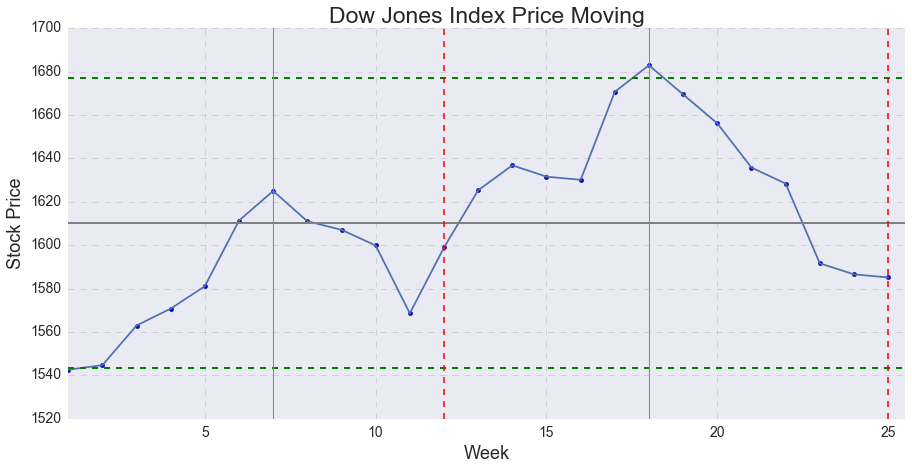

In [15]:
#To see price moving for Dow Jones market
price = df[['week', 'weekly_price_mean']]
price = price.groupby(['week']).weekly_price_mean.sum()

#make graph for price moving in Dow Jones Index
plt.figure(figsize=(15,7))
plt.scatter(price.index, price.values)
plt.plot(price.index, price.values)
plt.xlabel('Week', fontsize=18)
plt.ylabel('Stock Price', fontsize=18)
plt.title('Dow Jones Index Price Moving', fontsize=23)

plt.grid(axis='x', color='grey', linestyle='--', lw=0.5, alpha=0.5)
plt.grid(axis='y',color='grey', linestyle='--', lw=0.5, alpha=0.5)

plt.xlim(1, 25.5)
plt.tick_params(axis='both', labelsize=14)

plt.axhline(price.values.mean(), color='grey',linewidth = 2)
plt.axhline(1.8*np.std(price) + price.mean(), color='green', linestyle='--', linewidth=2)
plt.axhline(price.mean() - 1.8*np.std(price), color='green', linestyle='--', linewidth=2)
plt.axvline(np.argmax(price.values[:12])+1, color='c', linewidth=1)
plt.axvline(np.argmax(price.values[12:25])+13, color='c', linewidth=1)
plt.axvline(12, color='red', linestyle='--', linewidth=1.5)
plt.axvline(25, color='red', linestyle='--', linewidth=1.5)
print('Mean Price Line(Grey): $', round(price.values.mean(), 2))
print('Upper Std. Line(Green): $', round(1.8*np.std(price) + price.mean(), 2))
print('Lower Std. Line(Green): $', round(price.mean() - 1.8*np.std(price), 2))
print('Max Price each Quater(Cyan): Week ', np.argmax(price.values[:12])+1, 'in Q1.\n\t\t\t     Week', \
                                           np.argmax(price.values[12:25])+13, 'in Q2.');

Calculate risk variance;
>$Risk~ Variance(\%) = \pm \dfrac{1.8~ X~ Standard~ Diviation}{Stock~ Price}~ X~100$
>>Risk Variance tells that '+' and '-' price movement from Mean Price.

In [16]:
#Dow Jones index move in range +/-1.8 * standard deviation which I can called 'Risk Varience'.
#riskVar is that every stock have different range of price, so need to normalize all stock in same line
stD = df.groupby(['stock']).weekly_price_mean.std()
halfMean = df.groupby(['stock']).weekly_price_mean.mean().values
riskVar = 1.8*stD*100/halfMean

In [17]:
#calculate percentage of price chage for half year in each stocks
per_change = (df[df['week']==12]['weekly_price_mean'].values - df[df['week']==1]['weekly_price_mean'].values)/df[df['week']==1]['weekly_price_mean'].values

In [18]:
#clean data groupby stocks in order to classify stock
index = df.stock.unique()
df = pd.DataFrame(riskVar, index=index)
df['per_change'] = per_change
df = df.rename(columns={'weekly_price_mean':'risk_var'})

In [19]:
df.head(2)

,risk_var,per_change
AA,7.773989,0.034445
AXP,9.073533,0.020865


### 2-1. Clustering with KMeans

In [20]:
#check the data before clustering
df.risk_var[:2], df.per_change[:2]

(AA     7.773989
 AXP    9.073533
 Name: risk_var, dtype: float64, AA     0.034445
 AXP    0.020865
 Name: per_change, dtype: float64)

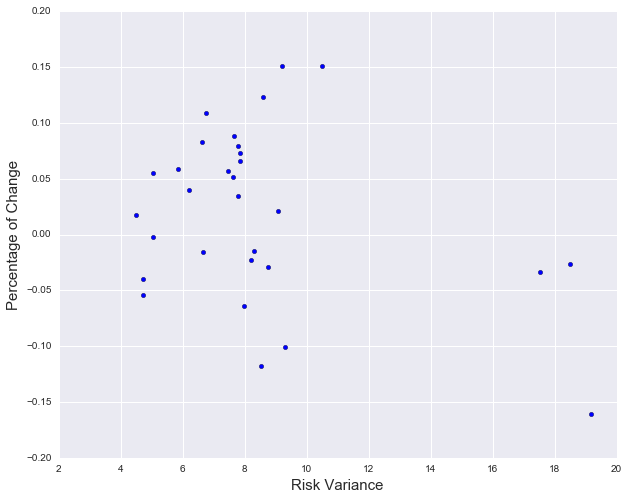

In [21]:
#Scatter plot each stocks
plt.figure(figsize=(10,8))
plt.scatter(df.risk_var, df.per_change)
plt.xlabel('Risk Variance', fontsize=15)
plt.ylabel('Percentage of Change', fontsize=15);

In [22]:
df.values[:2]

array([[ 7.77398915,  0.03444547],
       [ 9.0735332 ,  0.02086523]])

In [23]:
def distErr(model, data, pred, cluster):
    dist = 0
    for i in range(cluster):
        sample = data[pred == i]
        dist += (np.linalg.norm(sample - model.cluster_centers_[i]))**2
        
    return dist

def plot_Wk(data, clusters):
    '''
    Input:
        data - (DataFrame) Data to cluster on
        clusters - (list) List containing the number of clusters to check for
    Output:
        Plot showing the within cluster sum of squares
    '''
    x = data.values
    listWK = []
    
    for cen in clusters:
        km = KMeans(n_clusters=cen)
        km.fit(x)
        pred = km.predict(x)
        listWK.append(distErr(km, data, pred, cen))        
        
    plt.figure(figsize=(10,8))
    plt.plot(clusters, listWK)
    plt.xlabel('Number of Clusters', fontsize=12)
    plt.ylabel('Sum of Distance Error', fontsize=12);

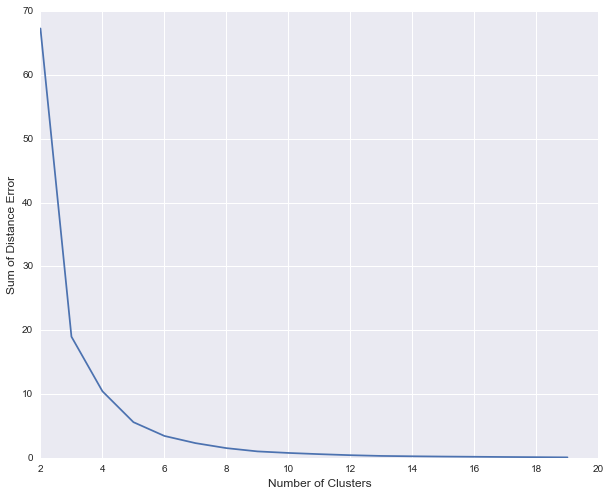

In [24]:
plot_Wk(df, np.arange(2,20))

In [25]:
def plot_silhouette(data,clusters):
    '''
    Input:
        data - (DataFrame) Data to cluster on
        clusters - (list) List containing the number of clusters to check for
    Output:
        Plot showing the silhouette score for different numbers of centroids
    '''  
    x = data.values
    listSilhouette = []

    for k in clusters:
        km = KMeans(n_clusters=k)
        km.fit(x)
        listSilhouette.append(silhouette_score(x, km.labels_, metric='euclidean'))
        
    plt.figure(figsize=(10,8))
    plt.plot(clusters, listSilhouette)
    plt.xlabel('Number of Clusters', fontsize=14)
    plt.ylabel('Score for Silhouette', fontsize=14);

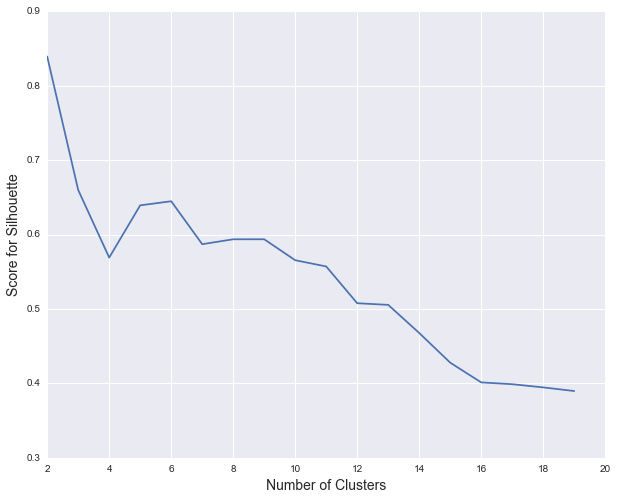

In [26]:
plot_silhouette(df, np.arange(2,20))

>From score of silhouette, 2 of clusters is the best clustering numbers.

In [27]:
#apply KMeans with 2 clusters
km2 = KMeans(n_clusters=2)
km2.fit(df.values)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [28]:
#check labels for clusters 2
unique(km2.labels_)

array([0, 1], dtype=int32)

In [30]:
#predict label with 2 clusters
pred2 = km2.predict(df.values)
Counter(pred2)

Counter({0: 27, 1: 3})

In [31]:
df.values[:, 1]

array([ 0.03444547,  0.02086523,  0.05717336, -0.02668316,  0.15073823,
       -0.16111111,  0.15112144,  0.07914642,  0.08868936,  0.0657538 ,
        0.0590684 , -0.03378687,  0.08294393, -0.0288635 , -0.06362913,
        0.05200023, -0.01501788, -0.00174934, -0.01576078,  0.05535194,
       -0.1174067 , -0.10037962,  0.12312604, -0.05454123, -0.0223378 ,
        0.07340834,  0.03969408,  0.01750517, -0.04020448,  0.10851598])

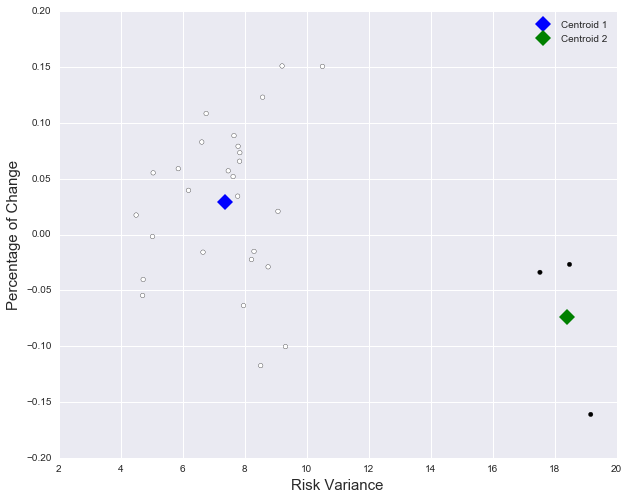

In [32]:
#plot kmean cluster graph with 2 clusters
plt.figure(figsize=(10,8))
plt.scatter(df.values[:, 0], df.values[:, 1], c=pred2)
plt.plot(km2.cluster_centers_[0][0], km2.cluster_centers_[0][1], 'D', label='Centroid 1', color='b', markersize=12)
plt.plot(km2.cluster_centers_[1][0], km2.cluster_centers_[1][1], 'D', label='Centroid 2', color='g', markersize=12)
plt.xlabel('Risk Variance', fontsize=15)
plt.ylabel('Percentage of Change', fontsize=15)
plt.legend();

### 2-2 Clustering with GMM

In [33]:
def plot_GMM(data, labels):
    '''
    Input:
        data - (DataFrame) Data to cluster on
        labels - (list) List containing the labels for each datapoint
    Output:
        Plot showing the original datapoints and cluster centers found by GMM
    '''

    plt.figure(figsize=(10,8))
    gm = GaussianMixture(n_components=len(np.unique(labels))).fit(data)
    cen_color = ['r', 'b', 'g', 'k', 'c', 'm', 'w']
    
    for i, df_ in enumerate(gm.means_):
        plt.plot(df_[0], df_[1], 'D', label='Centroid' + ' '+ str(i+1), color=np.random.choice(cen_color), markersize=12)
    
    plt.legend()
    plt.scatter(data[:,0], data[:,1], c=labels)
    plt.xlabel('Risk Variance', fontsize=15)
    plt.ylabel('Percentage of Change', fontsize=15);

In [34]:
def plot_silhouette_GMM(data, clusters):
    '''
    Input:
        data - (DataFrame) Data to cluster on
        clusters - (list) List containing the number of clusters to check for
    Output:
        Plot showing the silhouette score for different numbers of 
    '''  
    listSilhouette = []
    for g in clusters:
        gm = GaussianMixture(n_components=g)
        gm.fit(data)
        label = gm.predict(data)
        listSilhouette.append(silhouette_score(data, label, metric='euclidean'))
    
    plt.figure(figsize=(10,8))
    plt.plot(clusters, listSilhouette)
    plt.xlabel('Number of Clusters', fontsize=14)
    plt.ylabel('Score for Silhouette', fontsize=14);

In [35]:
df.values[:2]

array([[ 7.77398915,  0.03444547],
       [ 9.0735332 ,  0.02086523]])

In [36]:
gm2 = GaussianMixture(n_components=2).fit(df.values)

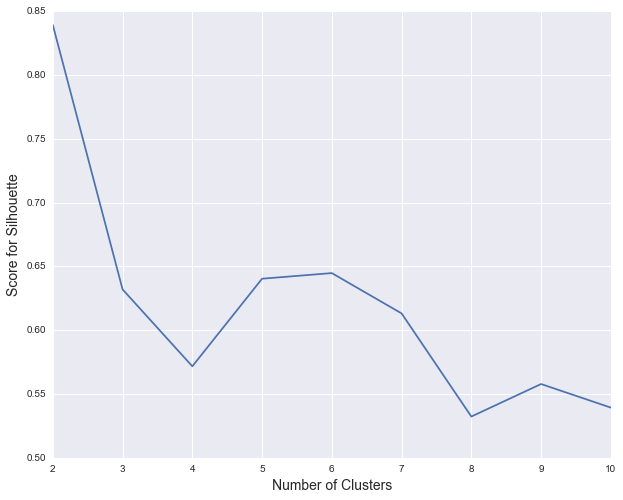

In [37]:
#check the best number of clusters
plot_silhouette_GMM(df.values, np.arange(2, 11))

>From score of silhouette, 2 of clusters is the best clustering numbers.

In [38]:
#best number of clusters
label2 = gm2.predict(df.values)

In [39]:
#compare with kmean
print(' GMM:   ', Counter(label2))
#predict label with 3 clusters
print('KMeans: ',Counter(pred2))

 GMM:    Counter({0: 27, 1: 3})
KMeans:  Counter({0: 27, 1: 3})


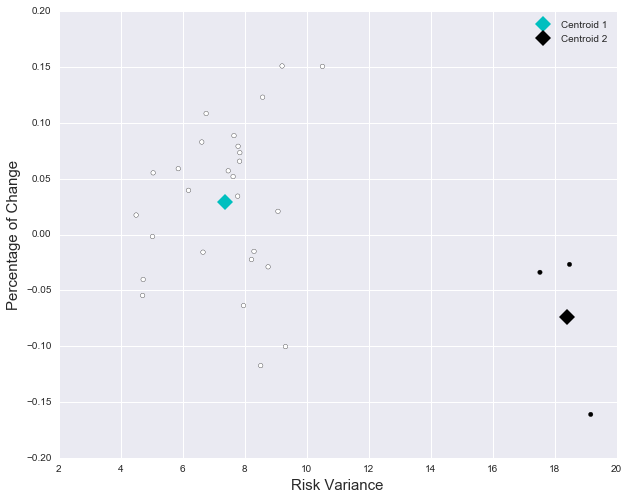

In [40]:
plot_GMM(df.values, label2)

>GMM and KMean have the same clustering results.

### 2-3 Make label into two Group of stock.

In [41]:
#check the label
pred2

array([0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [42]:
df.head(2)

,risk_var,per_change
AA,7.773989,0.034445
AXP,9.073533,0.020865


In [43]:
#add clustering labels
df['group'] = pred2
df.head(2)

,risk_var,per_change,group
AA,7.773989,0.034445,0
AXP,9.073533,0.020865,0


In [44]:
#setup Investable group
investable = df[df['group']==0]
investable = investable.drop('group',axis=1)

#setup more risk group
danger = df[df['group']==1]
danger = danger.drop('group',axis=1)

In [45]:
investable.head()

,risk_var,per_change
AA,7.773989,0.034445
AXP,9.073533,0.020865
BA,7.468744,0.057173
CAT,10.507776,0.150738
CVX,9.206462,0.151121


In [46]:
danger

,risk_var,per_change
BAC,18.477688,-0.026683
CSCO,19.161509,-0.161111
HPQ,17.523696,-0.033787


In [47]:
stock1 = investable.index.values
stock2 = danger.index.values
stock1_risk_mean = investable['risk_var'].mean()
stock2_risk_mean = danger['risk_var'].mean()
print('=== Investable Stock ========================================================')
print(' Investable Stock:\n', stock1,'\n')
print(' Average of Price Moving Range(%):\n', '+/-', round(stock1_risk_mean, 2), '%')
print('============================================================================\n')
print('=== Danger Stock ========================================================')
print(' Danger Stock:\n', stock2, '\n')
print(' Average of Price Moving Range(%):\n', '+/-', round(stock2_risk_mean, 2), '%')
print('============================================================================')

=== Investable Stock ========================================================
 Investable Stock:
 ['AA' 'AXP' 'BA' 'CAT' 'CVX' 'DD' 'DIS' 'GE' 'HD' 'IBM' 'INTC' 'JNJ' 'JPM'
 'KRFT' 'KO' 'MCD' 'MMM' 'MRK' 'MSFT' 'PFE' 'PG' 'T' 'TRV' 'UTX' 'VZ' 'WMT'
 'XOM'] 

 Average of Price Moving Range(%):
 +/- 7.35 %

=== Danger Stock ========================================================
 Danger Stock:
 ['BAC' 'CSCO' 'HPQ'] 

 Average of Price Moving Range(%):
 +/- 18.39 %


### 3. Second Clustering in Investable Group.

### 3-1 Clustering with KMean for Investable Group.

In [48]:
investable.head(2)

,risk_var,per_change
AA,7.773989,0.034445
AXP,9.073533,0.020865


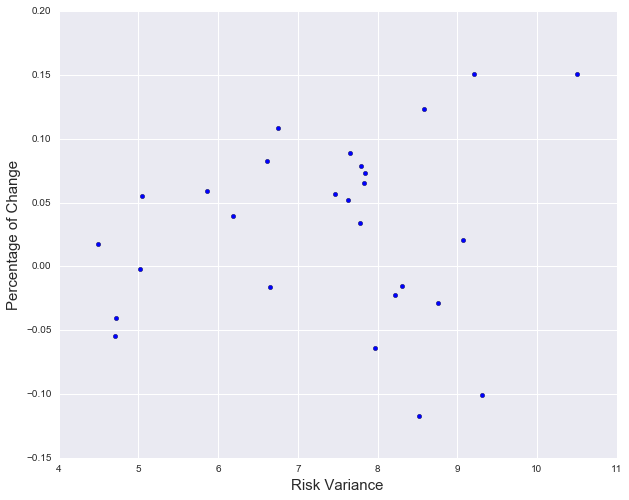

In [49]:
#Scatter plot for investable group
plt.figure(figsize=(10,8))
plt.scatter(investable.risk_var, investable.per_change)
plt.xlabel('Risk Variance', fontsize=15)
plt.ylabel('Percentage of Change', fontsize=15);

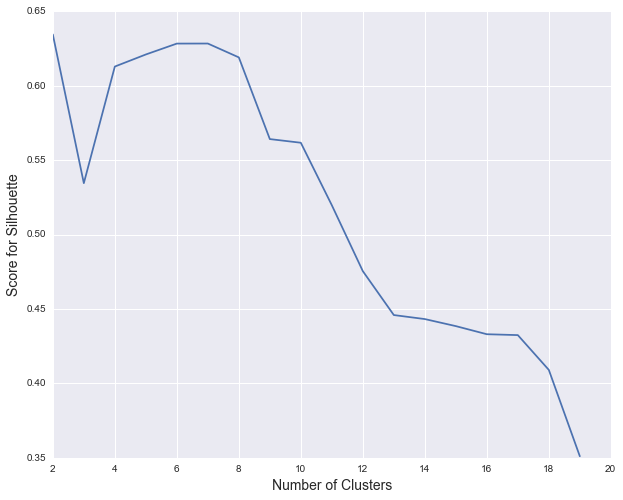

In [50]:
#find the number of clustering in ivestable group
plot_silhouette(investable, np.arange(2,20))

>From score of silhouette, 2 of clusters is the best clustering numbers.

In [51]:
#apply KMeans with 2 clusters
km3 = KMeans(n_clusters=2)
km3.fit(investable.values)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [52]:
#check labels for clusters 2
unique(km3.labels_)

array([0, 1], dtype=int32)

In [53]:
#predict label with 2 clusters
pred3 = km3.predict(investable.values)
Counter(pred3)

Counter({0: 17, 1: 10})

In [54]:
investable.values[:, 1]

array([ 0.03444547,  0.02086523,  0.05717336,  0.15073823,  0.15112144,
        0.07914642,  0.08868936,  0.0657538 ,  0.0590684 ,  0.08294393,
       -0.0288635 , -0.06362913,  0.05200023, -0.01501788, -0.00174934,
       -0.01576078,  0.05535194, -0.1174067 , -0.10037962,  0.12312604,
       -0.05454123, -0.0223378 ,  0.07340834,  0.03969408,  0.01750517,
       -0.04020448,  0.10851598])

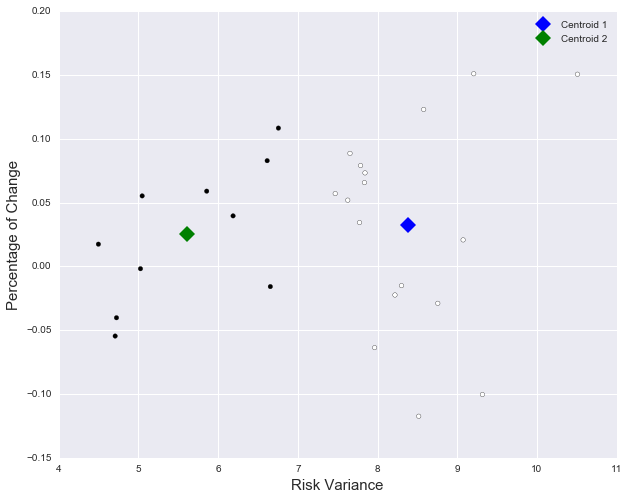

In [55]:
#plot kmean cluster graph with 2 clusters
plt.figure(figsize=(10,8))
plt.scatter(investable.values[:, 0], investable.values[:, 1], c=pred3)
plt.plot(km3.cluster_centers_[0][0], km3.cluster_centers_[0][1], 'D', label='Centroid 1', color='b', markersize=12)
plt.plot(km3.cluster_centers_[1][0], km3.cluster_centers_[1][1], 'D', label='Centroid 2', color='g', markersize=12)
plt.xlabel('Risk Variance', fontsize=15)
plt.ylabel('Percentage of Change', fontsize=15)
plt.legend();

### 3-2 Clustering with GMM for Investable Group.

In [736]:
gm3 = GaussianMixture(n_components=2).fit(investable.values)

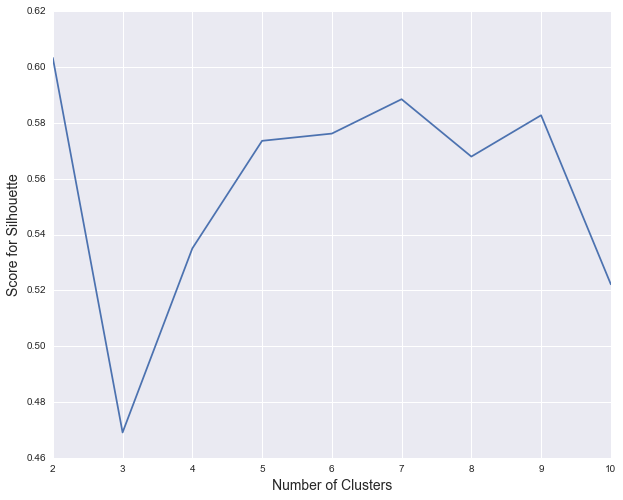

In [743]:
#check the best number of clusters
plot_silhouette_GMM(investable.values, np.arange(2, 11))

>From score of silhouette, 2 of clusters is still the best clustering numbers for GMM.

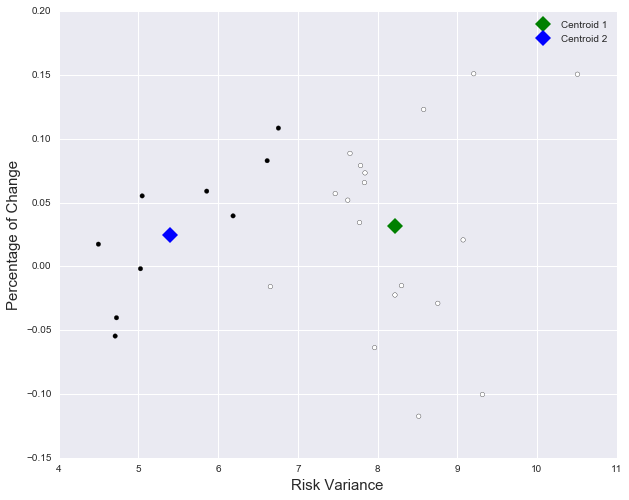

In [744]:
label3 = gm3.predict(investable.values)
plot_GMM(investable.values, label3)

### 3-3 Make label into two Group of stock.

In [56]:
#check the label
pred3

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 1], dtype=int32)

In [57]:
investable.head(2)

,risk_var,per_change
AA,7.773989,0.034445
AXP,9.073533,0.020865


In [58]:
#add clustering labels
investable['group'] = pred3
investable.shape

(27, 3)

In [59]:
#setup Investable group
investable2 = investable[investable['group']==1]
investable2 = investable2.drop('group',axis=1)

#setup more risk group
danger2 = investable[investable['group']==0]
danger2 = danger2.drop('group',axis=1)

In [60]:
investable2.shape

(10, 2)

In [61]:
stock3 = investable2.index.values
stock4 = danger2.index.values
stock3_risk_mean = investable2['risk_var'].mean()
stock4_risk_mean = danger2['risk_var'].mean()
print('=== Investable Stock ========================================================')
print(' Investable Stock:\n', stock3,'\n')
print(' Average of Price Moving Range(%):\n', '+/-', round(stock3_risk_mean, 2), '%')
print('============================================================================\n')
print('=== Danger Stock ========================================================')
print(' Danger Stock:\n', stock4, '\n')
print(' Average of Price Moving Range(%):\n', '+/-', round(stock4_risk_mean, 2), '%')
print('============================================================================')

=== Investable Stock ========================================================
 Investable Stock:
 ['HD' 'IBM' 'KO' 'MCD' 'MMM' 'PG' 'UTX' 'VZ' 'WMT' 'XOM'] 

 Average of Price Moving Range(%):
 +/- 5.61 %

=== Danger Stock ========================================================
 Danger Stock:
 ['AA' 'AXP' 'BA' 'CAT' 'CVX' 'DD' 'DIS' 'GE' 'INTC' 'JNJ' 'JPM' 'KRFT'
 'MRK' 'MSFT' 'PFE' 'T' 'TRV'] 

 Average of Price Moving Range(%):
 +/- 8.38 %


### 4. Third Clustering in Investable Group.

### 4-1 Clustering with KMean for Investable Group.

In [62]:
investable2.head(2)

,risk_var,per_change
HD,5.856409,0.059068
IBM,6.615161,0.082944


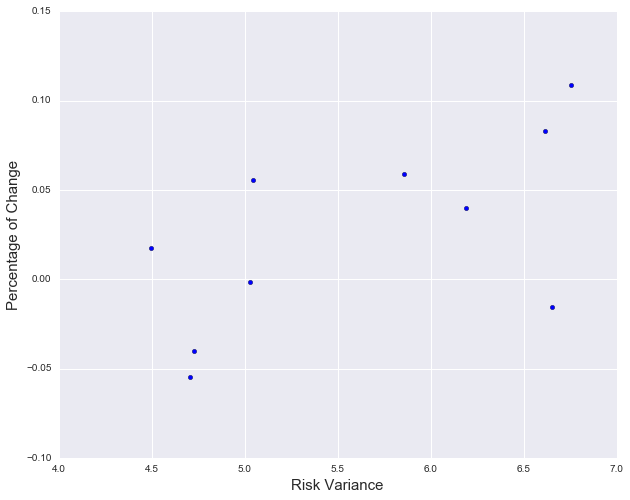

In [63]:
#Scatter plot for second investable group
plt.figure(figsize=(10,8))
plt.scatter(investable2.risk_var, investable2.per_change)
plt.xlabel('Risk Variance', fontsize=15)
plt.ylabel('Percentage of Change', fontsize=15);

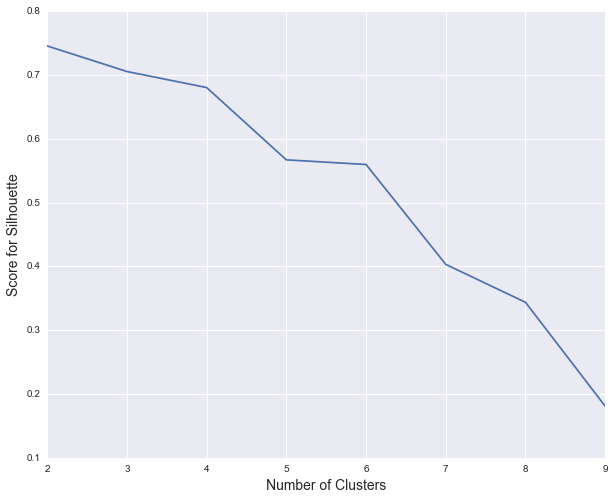

In [64]:
#find the number of clustering in second investable group
plot_silhouette(investable2, np.arange(2,10))

>From score of silhouette, 2 of clusters is the best clustering numbers.

In [65]:
#apply KMeans with 2 clusters
km4 = KMeans(n_clusters=2)
km4.fit(investable2.values)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [66]:
#check labels for clusters 2
unique(km4.labels_)

array([0, 1], dtype=int32)

In [67]:
#predict label with 2 clusters
pred4 = km4.predict(investable2.values)
Counter(pred4)

Counter({0: 5, 1: 5})

In [68]:
investable2.values[:, 1]

array([ 0.0590684 ,  0.08294393, -0.00174934, -0.01576078,  0.05535194,
       -0.05454123,  0.03969408,  0.01750517, -0.04020448,  0.10851598])

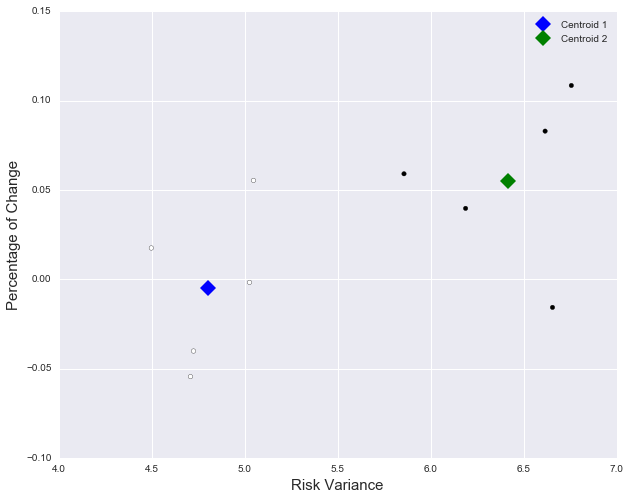

In [69]:
#plot kmean cluster graph with 2 clusters
plt.figure(figsize=(10,8))
plt.scatter(investable2.values[:, 0], investable2.values[:, 1], c=pred4)
plt.plot(km4.cluster_centers_[0][0], km4.cluster_centers_[0][1], 'D', label='Centroid 1', color='b', markersize=12)
plt.plot(km4.cluster_centers_[1][0], km4.cluster_centers_[1][1], 'D', label='Centroid 2', color='g', markersize=12)
plt.xlabel('Risk Variance', fontsize=15)
plt.ylabel('Percentage of Change', fontsize=15)
plt.legend();

### 4-2 Clustering with GMM for Investable Group.

In [70]:
gm4 = GaussianMixture(n_components=2).fit(investable2.values)

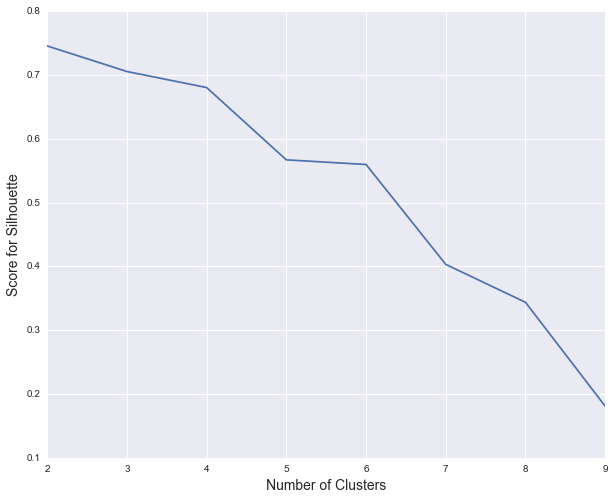

In [71]:
#check the best number of clusters
plot_silhouette_GMM(investable2.values, np.arange(2, 10))

>From score of silhouette, 2 of clusters is still the best clustering numbers for GMM.

### 3-3 Make label into two Group of stock, and Recommand Stock.

In [72]:
#check the label
pred4

array([1, 1, 0, 1, 0, 0, 1, 0, 0, 1], dtype=int32)

In [73]:
#add clustering labels
investable2['group'] = pred4
investable2.shape

(10, 3)

In [78]:
#setup Investable group
lowRisk = investable2[investable2['group']==0]
lowRisk = lowRisk.drop('group',axis=1)

#setup more risk group
highRisk = investable2[investable2['group']==1]
highRisk = highRisk.drop('group',axis=1)

In [79]:
lowRisk.shape, highRisk.shape

((5, 2), (5, 2))

* Cluster inside lowRisk and highRisk groups, and make set of recommad stock.

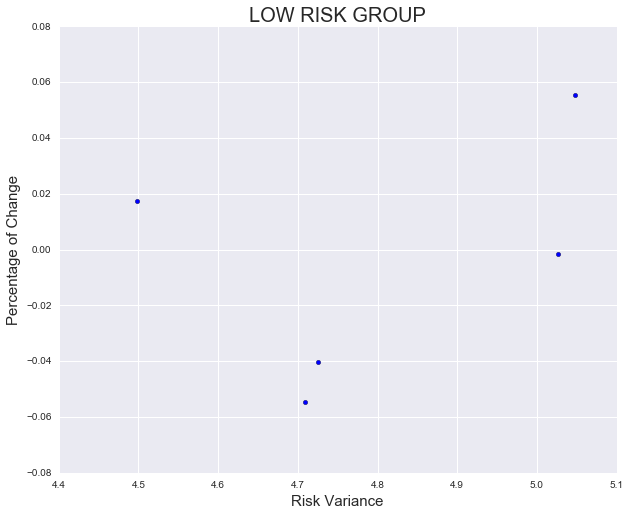

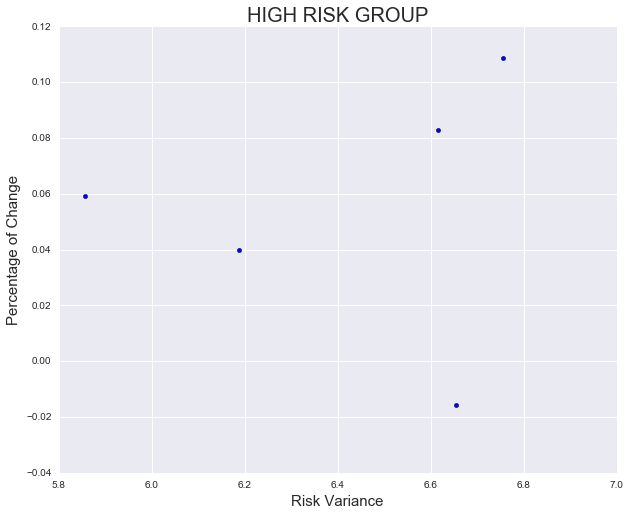

In [80]:
#Scatter plot for lowRisk group
plt.figure(figsize=(10,8))
plt.scatter(lowRisk.risk_var, lowRisk.per_change)
plt.title('LOW RISK GROUP', size=20)
plt.xlabel('Risk Variance', fontsize=15)
plt.ylabel('Percentage of Change', fontsize=15);

#Scatter plot for highRisk group
plt.figure(figsize=(10,8))
plt.scatter(highRisk.risk_var, highRisk.per_change)
plt.title('HIGH RISK GROUP', size=20)
plt.xlabel('Risk Variance', fontsize=15)
plt.ylabel('Percentage of Change', fontsize=15);

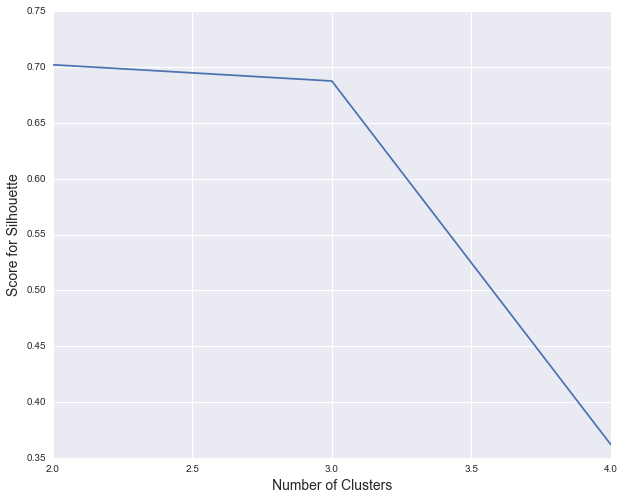

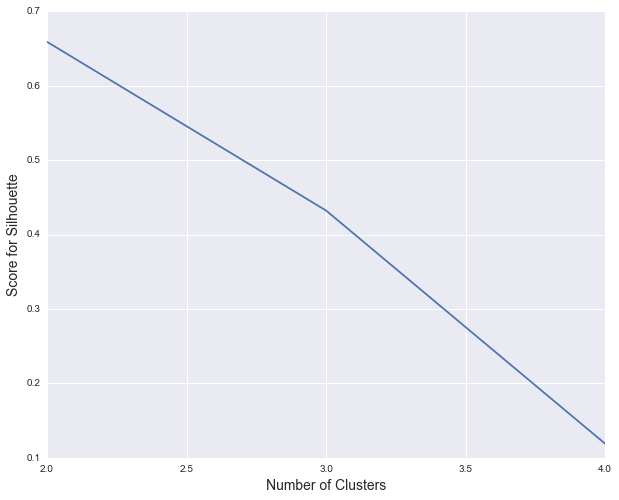

In [81]:
#find the number of clustering in lowRisk group
plot_silhouette(lowRisk, np.arange(2,5))

#find the number of clustering in highRisk group
plot_silhouette(highRisk, np.arange(2,5))

>From score of silhouette, 2 of clusters is the best clustering numbers for both low and high Risk groups.<br>
However, in lowRisk group, the score for 2 and 3 are pretty same, and after I tried n_clusters=2 into lowRisk group<br> n_clusters=3 result is better for recommad stock.


In [82]:
#apply KMeans with 2 clusters for lowRisk groups first, but I got better cluster for 3 clusters.
#apply KMeans with 3 clusters for lowRisk groups
km_low = KMeans(n_clusters=3)
km_low.fit(lowRisk.values)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [83]:
#apply KMeans with 2 clusters for highRisk groups
km_high = KMeans(n_clusters=2)
km_high.fit(highRisk.values)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [84]:
#predict label with 2 clusters for both groups
pred_low = km_low.predict(lowRisk.values)
Counter(pred_low)

Counter({0: 2, 1: 1, 2: 2})

In [85]:
pred_high = km_high.predict(highRisk.values)
Counter(pred_high)

Counter({0: 3, 1: 2})

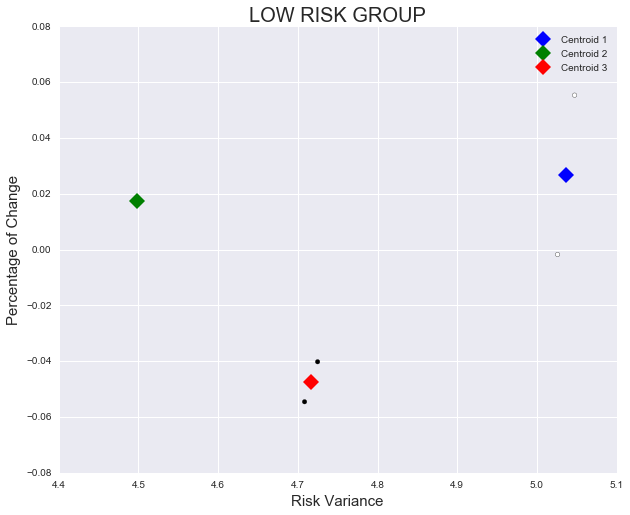

In [86]:
#plot kmean cluster graph with 2 clusters for lowRisk
plt.figure(figsize=(10,8))
plt.scatter(lowRisk.values[:, 0], lowRisk.values[:, 1], c=pred_low)
plt.plot(km_low.cluster_centers_[0][0], km_low.cluster_centers_[0][1], 'D', label='Centroid 1', color='b', markersize=12)
plt.plot(km_low.cluster_centers_[1][0], km_low.cluster_centers_[1][1], 'D', label='Centroid 2', color='g', markersize=12)
plt.plot(km_low.cluster_centers_[2][0], km_low.cluster_centers_[2][1], 'D', label='Centroid 3', color='r', markersize=12)
plt.title('LOW RISK GROUP', size=20)
plt.xlabel('Risk Variance', fontsize=15)
plt.ylabel('Percentage of Change', fontsize=15)
plt.legend();

In [87]:
#add clustering labels
lowRisk['group'] = pred_low
lowRisk

,risk_var,per_change,group
KO,5.025828,-0.001749,0
MMM,5.047180,0.055352,0
PG,4.708411,-0.054541,2
VZ,4.497935,0.017505,1
WMT,4.724775,-0.040204,2


* recommand stock in lowRisk group.

In [88]:
#the pupose for invest stock is get profit, so only take positive per_change
lowRisk = lowRisk[lowRisk['per_change'] > 0]
lowRisk = lowRisk.sort(['risk_var'], ascending=[1])
lowRisk

/Users/yun/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


,risk_var,per_change,group
VZ,4.497935,0.017505,1
MMM,5.047180,0.055352,0


>From lowRisk group the most important thing is the risk_var, so recommand stock based on people investing style.

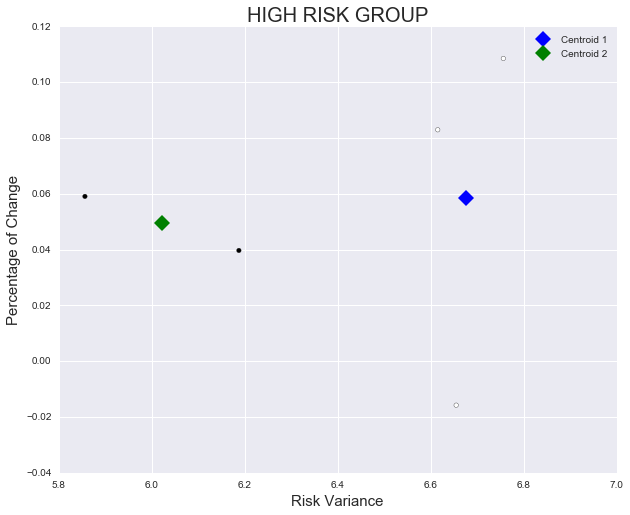

In [89]:
#plot kmean cluster graph with 2 clusters for highRisk
plt.figure(figsize=(10,8))
plt.scatter(highRisk.values[:, 0], highRisk.values[:, 1], c=pred_high)
plt.plot(km_high.cluster_centers_[0][0], km_high.cluster_centers_[0][1], 'D', label='Centroid 1', color='b', markersize=12)
plt.plot(km_high.cluster_centers_[1][0], km_high.cluster_centers_[1][1], 'D', label='Centroid 2', color='g', markersize=12)
plt.title('HIGH RISK GROUP', size=20)
plt.xlabel('Risk Variance', fontsize=15)
plt.ylabel('Percentage of Change', fontsize=15)
plt.legend();

* recommand stock in highRisk group.

In [90]:
pred_high

array([1, 0, 0, 1, 0], dtype=int32)

In [91]:
#add clustering labels
highRisk['group'] = pred_high
highRisk

,risk_var,per_change,group
HD,5.856409,0.059068,1
IBM,6.615161,0.082944,0
MCD,6.654794,-0.015761,0
UTX,6.187506,0.039694,1
XOM,6.756144,0.108516,0


In [92]:
#the pupose for invest stock is get profit, so only take positive per_change
#sorted by per_chage
highRisk = highRisk[highRisk['per_change'] > 0]
highRisk = highRisk.sort(['per_change'], ascending=[0])
highRisk

/Users/yun/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,risk_var,per_change,group
XOM,6.756144,0.108516,0
IBM,6.615161,0.082944,0
HD,5.856409,0.059068,1
UTX,6.187506,0.039694,1


>From highRisk group the most important thing is the per_change, so recommand stock based on people investing style.

### Recommadation Stock.

In [93]:
lowRisk

,risk_var,per_change,group
VZ,4.497935,0.017505,1
MMM,5.047180,0.055352,0


In [94]:
highRisk

,risk_var,per_change,group
XOM,6.756144,0.108516,0
IBM,6.615161,0.082944,0
HD,5.856409,0.059068,1
UTX,6.187506,0.039694,1


In [95]:
stockList = []
lowList = list(lowRisk.index.values)
highList = list(highRisk.index.values)
stockList.append(lowList)
stockList.append(highList)
stockList

[['VZ', 'MMM'], ['XOM', 'IBM', 'HD', 'UTX']]

In [96]:
def makeList(low, high):
    s = [['VZ', 'MMM'], ['XOM', 'IBM', 'HD', 'UTX']]
    recom = []
    for i in range(low):
        recom.append(s[0][i])
    for j in range(high):
        recom.append(s[1][j])
    return recom

def recommadation(style, n_stock):
    if n_stock <= 6:
        if style == 'aggressive':
            return makeList(1, n_stock-1)
        elif style == 'safe':
            return makeList(2, n_stock-2)
        else:
            print('Choose your Investing Style or check typo for your style.')
    else:
        print('I can recommad Maximun 6 stocks.')
        print('I can recommad to you should have 3~4 different stock in short term investment.')
        print('Short term means less than 1 quarter.')
        print('Try number of recommand stock for 2 to 5.')

In [97]:
recommadation('aggressive', 3)

['VZ', 'XOM', 'IBM']

In [98]:
recommadation('safe', 4)

['VZ', 'MMM', 'XOM', 'IBM']

In [101]:
recommadation('safe', 8)

I can recommad Maximun 6 stocks.
I can recommad to you should have 3~4 different stock in short term investment.
Short term means less than 1 quarter.
Try number of recommand stock for 2 to 5.


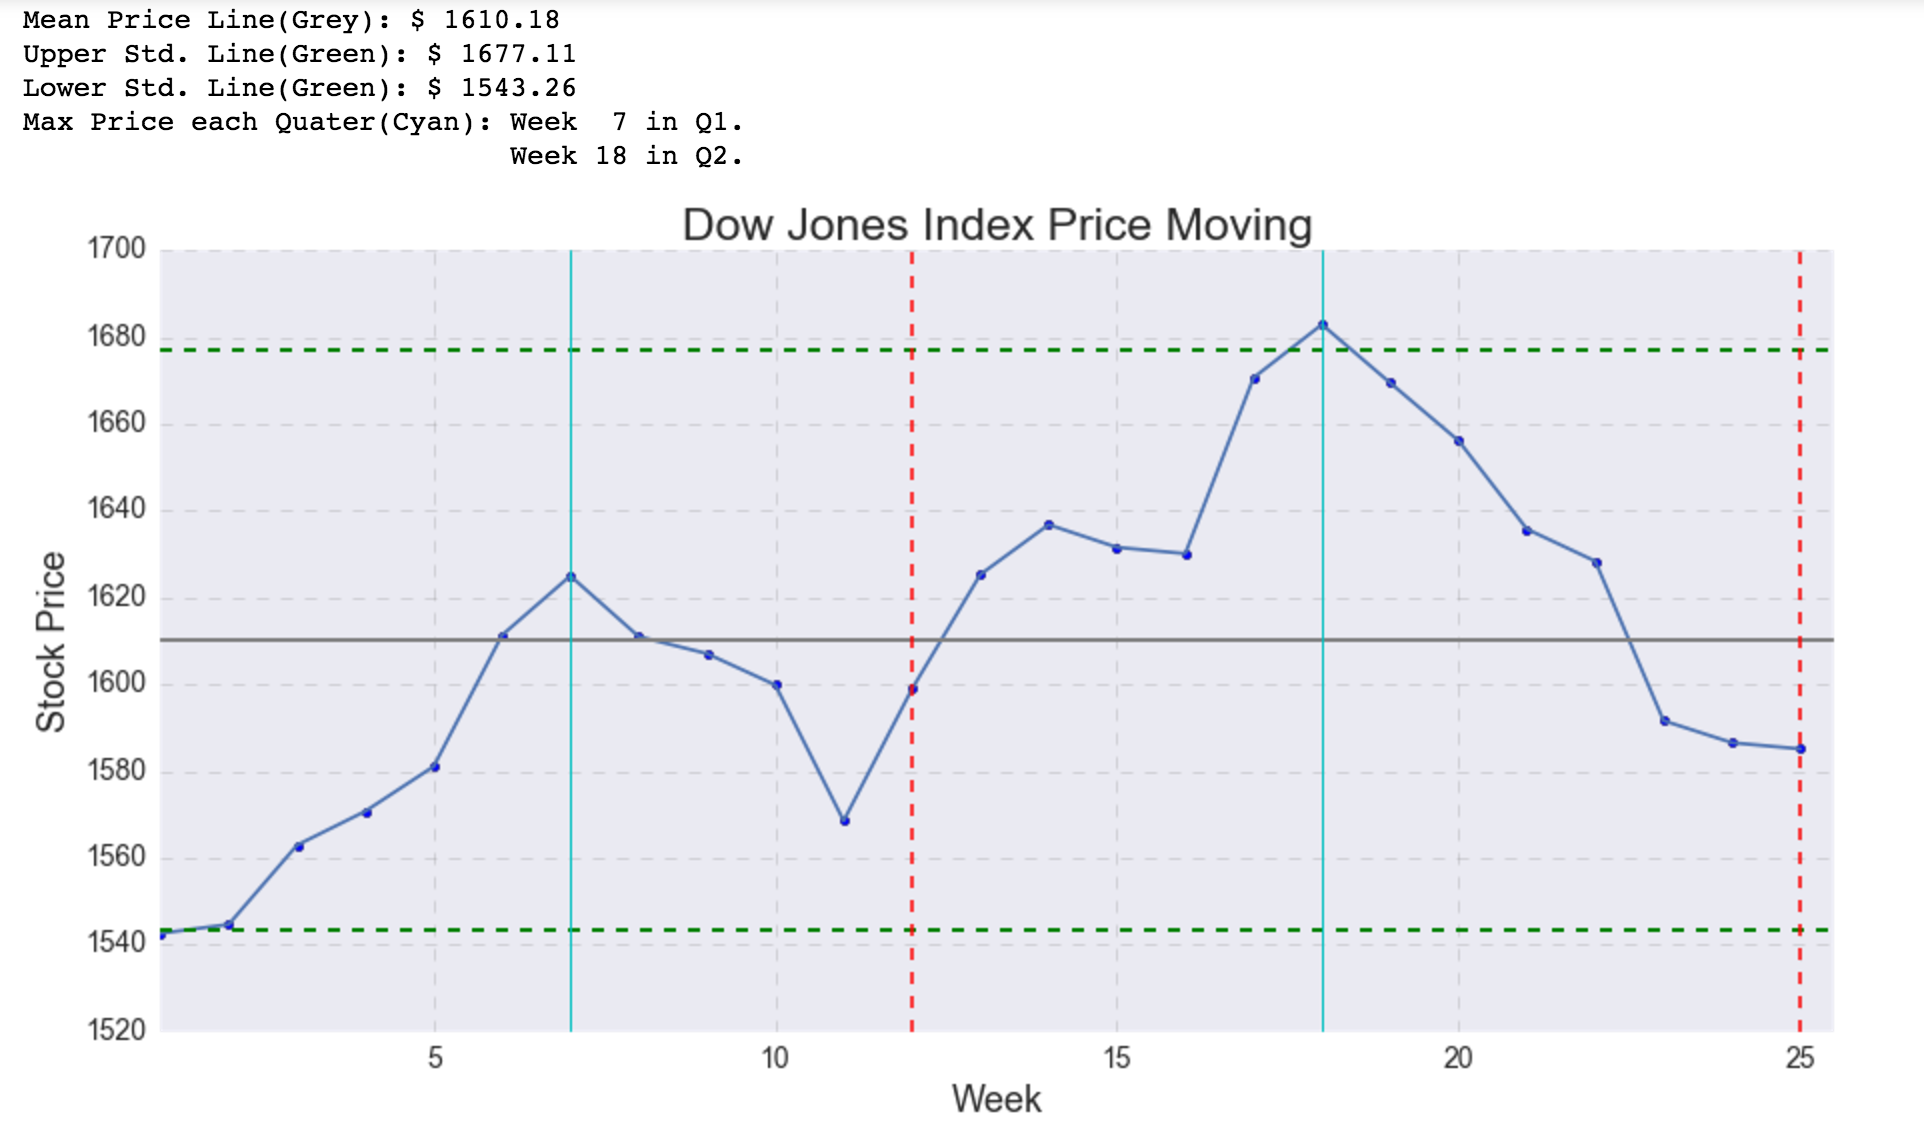

In [99]:
from IPython.display import Image
Image(filename='DowJones.png')

>Based the image, price of DowJones stocks move up first 7~8 weeks of the each quarter, and price move down until end of quarter.<br>
Hence, the time for buying stocks which belong to Dow Jones Index is week0 in each quarter(end week each quarter).
Then, hold 7~8 weeks for stocks, then sell the stocks.

In [100]:
print('With Aggressive investing style, I recommand: ', recommadation('aggressive', 4))
print('With    Safe    investing style, I recommand: ', recommadation('safe', 3))

With Aggressive investing style, I recommand:  ['VZ', 'XOM', 'IBM', 'HD']
With    Safe    investing style, I recommand:  ['VZ', 'MMM', 'XOM']


In [103]:
recommadation('safe', 8)

I can recommad Maximun 6 stocks.
I can recommad to you should have 3~4 different stock in short term investment.
Short term means less than 1 quarter.
Try number of recommand stock for 2 to 5.


In [105]:
recommadation('dont know', 4)

Choose your Investing Style or check typo for your style.


>In clustering, I used two kinds of clustering algorithm; bKMean and GMM algorithm. 
I clustered three times from cleaning data to get final groups; lowRisk and highRisk groups.
I used KMean and GMM in clustering at the first two clustering, but their results are not really different, so I used only KMean at the last clustering. <br>
KMean clustering is kind of sensitive, but if you clean the data well, it is a great algorithm to clustering.<br>
This dataset contains weekly price moving and dividend during the first two quarter in 2011 for each stocks, so I think that the data set is a kind of small to clustering and recommending stocks as compare with real world. Applying more data set (longer period times), I can get better system for recommending and clustering. 